In [2]:
from easydict import EasyDict as edict
import os
import numpy as np
import matplotlib.pyplot as plt

import mindspore
import mindspore.dataset as ds
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [3]:
cfg = edict({
    'data_size': 3616,
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MAX': 512,
    
    'loss_scale_num':1024,
    
})

[WARNING] ME(23956:23072,MainProcess):2023-04-11-11:00:56.228.397 [mindspore\dataset\core\validator_helpers.py:806] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(23956:23072,MainProcess):2023-04-11-11:00:56.232.384 [mindspore\dataset\core\validator_helpers.py:806] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(23956:23072,MainProcess):2023-04-11-11:00:56.233.381 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(23956:23072,MainProcess):2023-04-11-11:00:56.233.381 [mindspore\dataset\core\validator_helpers.py:806] 'C

训练数据集数量： 3616
测试数据集数量： 3618
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 2


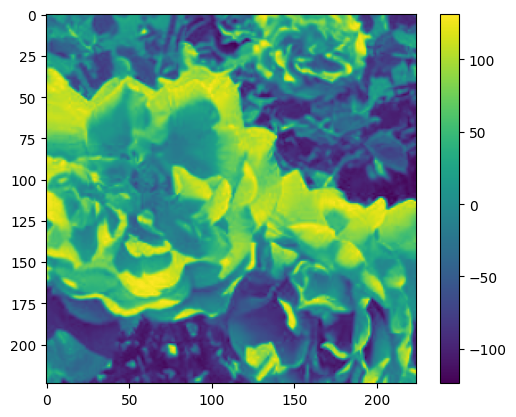

In [4]:
def read_data(path,config,usage="train"):
    dataset = ds.ImageFolderDataset(path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
    decode_op = vision.Decode() 
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    horizontal_flip_op = vision.RandomHorizontalFlip()
    channelswap_op = vision.HWC2CHW()
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)
    
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    if usage == 'train':
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    
    dataset = dataset.repeat(1)
    
    dataset.map_model = 4

    return dataset

de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('测试数据集数量：',de_test.get_dataset_size())

data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show() 

In [5]:
"""ResNet."""

def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """

    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion  
        
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        
        self.relu = nn.ReLU()

        self.down_sample = False
        
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        if self.down_sample:
        self.add = ops.Add()

    def construct(self, x): 
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)
        
        out = self.add(out, identity)
        out = self.relu(out)

        return out

class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])
        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        
        layers = []
        
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)
    
    def construct(self, x): 



        return out

def resnet50(class_num=5):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """


In [9]:
net=resnet50(class_num=cfg.num_class)

param_dict = load_checkpoint("./data/resnet50_ascend_v170_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt")

print(param_dict)

param_dict["end_point.weight"] = mindspore.Parameter(Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable")
param_dict["end_point.bias"]= mindspore.Parameter(Tensor(param_dict["end_point.bias"][:5,], mindspore.float32), name="variable")

loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * cfg.epoch_size,step_per_epoch=train_step_size, decay_epoch=cfg.epoch_size)

opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

loss_cb = LossMonitor(per_print_times=train_step_size)

ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)

ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)

metric = model.eval(de_test)
print(metric) 


In [ ]:
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])